<a href="https://colab.research.google.com/github/happyfranc/ml_project/blob/main/%08DL_project1_v3_3_%EB%B0%95%EC%9D%B4%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

생육 기간 예측 프로젝트

목적 및 배경 : 한 쌍의 이미지를 입력받아 작물의 생육 기간을 예측하는 모델 개발

데이터 정보 및 학습 진행 방식 : DACON "생육 기간 예측 경진대회" 데이터

2개 작물(청경채, 적상추)에 대한 생육 기간 경과일자별 이미지 데이터 저장
- 학습 : 753개(청경채 353개, 적상추 400개)
- 테스트 : 307개(청경채 139개, 적상추 168개)


작물별 이미지 2장씩을 다양하게 조합하여 2장의 이미지간 경과일을 기준으로 학습 및 평가 진행 예정

모델 평가 기준 : RMSE(Root Mean Squared Error)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import os
import random

In [55]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import optim
from torch import nn
from torchvision.transforms import ToTensor
from torchvision import transforms
from tqdm.auto import tqdm

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 파일 path
train_path = '/content/drive/MyDrive/ds_study/data/train_dataset'
test_path = '/content/drive/MyDrive/ds_study/data/test_dataset'

In [ ]:
# Data resize 저장 함수
def data_resize(species_nm,root_path):
  os.mkdir(root_path +'/'+ species_nm + '_resize')
  for sub_path in os.listdir(root_path +'/'+ species_nm): # 서브 폴더 생성
    os.mkdir(root_path +'/'+ species_nm + '_resize/' + sub_path)
    for image_path in glob(root_path +'/'+ species_nm + '/' + sub_path + '/*'): # 이미지 resize 및 저장
      image_file_name = image_path.split('/')[-1]
      img = Image.open(image_path)
      img = img.resize((224, 224))
      img.save(root_path +'/'+ species_nm + '_resize/' + sub_path + '/' + image_file_name)

In [ ]:
# BC train
#data_resize('BC',train_path)

In [ ]:
# LT train
#data_resize('LT',train_path)

In [ ]:
# BC test
#data_resize('BC',test_path)

In [ ]:
# LT test
#data_resize('LT',test_path)

In [ ]:
print(len(glob(train_path + '/BC/**/**')),len(glob(train_path + '/BC_resize/**/**')))

353 353


In [ ]:
print(len(glob(train_path + '/LT/**/**')),len(glob(train_path + '/LT_resize/**/**')))

400 400


In [ ]:
# 파일 이름에서 날짜 추출
def extract_day(file_name):
  day = int(file_name.split('.')[-2][-2:])
  return day

In [ ]:
# 파일 이름에서 날짜 추출 후 array 파일로 만들기
def make_day_array(file_name):
  day_array = np.array([extract_day(file_name) for file_name in file_name])
  return day_array

In [ ]:
# image path array 생성
def make_image_path_array(root_path):
  bc_directories = glob(root_path + '/BC_resize/*')
  lt_directories = glob(root_path + '/LT_resize/*')
  
  # bc 이미지 확인
  bc_image_path = []  
  for bc_path in bc_directories:
    images = glob(bc_path + '/*.png')
    bc_image_path.extend(images)
    print(len(bc_image_path))

  # lt 이미지 확인
  lt_image_path = []  
  for lt_path in lt_directories:
    images = glob(lt_path + '/*.png')
    lt_image_path.extend(images)
    print(len(lt_image_path))
    
  return bc_image_path, lt_image_path

In [ ]:
# DataFrame 만들기(columns = 파일 이름, 일자, 종)
def make_dataframe(root_path):
  bc_image_path, lt_image_path = make_image_path_array(root_path) # 데이터 저장 경로 입력 후 파일 리스트 생성
  bc_day_array = make_day_array(bc_image_path) # bc 파일 이름에서 날짜 추출 후 array 만들기
  lt_day_array = make_day_array(lt_image_path) # lt 파일 이름에서 날짜 추출 후 array 만들기

  bc_df = pd.DataFrame({"file_name": bc_image_path, 
                        "day" : bc_day_array})

  bc_df['species'] = 'bc' # 종 추가


  lt_df = pd.DataFrame({"file_name": lt_image_path,
                        "day" : lt_day_array})

  lt_df['species'] = 'lt' # 종 추가

  total_data_frame = pd.concat([bc_df, lt_df]).reset_index(drop=True)

  return total_data_frame

In [ ]:
#length만큼 2개씩 sampling한 결과 dataframe 만들기
def make_combination(length, species, data_frame, direct_name):
    before_file_path = []
    after_file_path = []
    time_delta = []

    for i in range(length):
      # 하위 폴더 중 랜덤하게 선택
      direct = random.randrange(0,len(direct_name))
      # 위에서 결정된 폴더를 선택
      temp = data_frame[data_frame['version'] == direct_name[direct]]

      # sample 이용해서 dataframe에서 2개 뽑기
      sample = temp[temp['species'] == species].sample(2)
      # day가 더 큰 sample을 after
      after = sample[sample['day'] == max(sample['day'])].reset_index(drop=True)
      # day가 더 작은 sample을 before
      before = sample[sample['day'] == min(sample['day'])].reset_index(drop=True)

      before_file_path.append(before.iloc[0]['file_name'])
      after_file_path.append(after.iloc[0]['file_name'])
      delta = int(after.iloc[0]['day'] - before.iloc[0]['day'])
      time_delta.append(delta)

    combination_df = pd.DataFrame({
        'before_file_path': before_file_path,
        'after_file_path': after_file_path,
        'time_delta': time_delta,
    })

    combination_df['species'] = species

    return combination_df

In [ ]:
# BC 폴더와 LT 폴더에 있는 하위 폴더를 저장한다.
bc_direct = glob(train_path + '/BC_resize/*')
bc_direct_name = [x[-5:] for x in bc_direct]
print(bc_direct_name)
lt_direct = glob(train_path + '/LT_resize/*')
lt_direct_name = [x[-5:] for x in lt_direct]
print(lt_direct_name)

['BC_09', 'BC_06', 'BC_07', 'BC_01', 'BC_02', 'BC_08', 'BC_04', 'BC_05', 'BC_03']
['LT_05', 'LT_03', 'LT_02', 'LT_04', 'LT_00', 'LT_07', 'LT_09', 'LT_08', 'LT_01', 'LT_06']


In [ ]:
# 하위 폴더에 있는 이미지들을 하위 폴더 이름과 매칭시켜서 저장한다.
bc_images = {key : glob(name + '/*.png') for key,name in zip(bc_direct_name, bc_direct)}
lt_images = {key : glob(name + '/*.png') for key,name in zip(lt_direct_name, lt_direct)}

In [ ]:
# 하위 폴더에 있는 이미지들에서 날짜 정보만 따로 저장한다.
bc_dayes = {key : make_day_array(bc_images[key]) for key in bc_direct_name}
lt_dayes = {key : make_day_array(lt_images[key]) for key in lt_direct_name}

In [ ]:
bc_dfs = []
for i in bc_direct_name:
    bc_df = pd.DataFrame({
        'file_name':bc_images[i],
        'day':bc_dayes[i],
        'species':'bc',
        'version':i
    })
    bc_dfs.append(bc_df)
    
lt_dfs = []
for i in lt_direct_name:
    lt_df = pd.DataFrame({
        'file_name':lt_images[i],
        'day':lt_dayes[i],
        'species':'lt',
        'version':i
    })
    lt_dfs.append(lt_df)

In [ ]:
# 데이터셋 만들기
# 1000개, 8 : 2
bc_dataframe = pd.concat(bc_dfs).reset_index(drop=True)
lt_dataframe = pd.concat(lt_dfs).reset_index(drop=True)
total_dataframe = pd.concat([bc_dataframe, lt_dataframe]).reset_index(drop=True)


bc_combination = make_combination(1000, 'bc', total_dataframe, bc_direct_name)
lt_combination = make_combination(1000, 'lt', total_dataframe, lt_direct_name)

bc_train = bc_combination.iloc[:800]
bc_valid = bc_combination.iloc[800:]

lt_train = lt_combination.iloc[:800]
lt_valid = lt_combination.iloc[800:]

train_set = pd.concat([bc_train, lt_train])
valid_set = pd.concat([bc_valid, lt_valid])

In [ ]:
# 데이터 csv파일로 저장 
total_dataframe.to_csv('/content/drive/MyDrive/ds_study/total_dataframe.csv', index=False)

bc_combination.to_csv('/content/drive/MyDrive/ds_study/bc_combination_1000.csv', index=False)
lt_combination.to_csv('/content/drive/MyDrive/ds_study/lt_combination_1000.csv', index=False)

In [ ]:
# train, valid 데이터 csv파일로 저장 
train_set.to_csv('/content/drive/MyDrive/ds_study/train_data.csv', index=False)
valid_set.to_csv('/content/drive/MyDrive/ds_study/valid_data.csv', index=False)

In [ ]:
#length만큼 2개씩 sampling한 결과 dataframe 만들기
def make_combination_diff(length, species, data_frame):
    before_file_path = []
    after_file_path = []
    time_delta = []

    for i in range(length):
      # sample 이용해서 dataframe에서 2개 뽑기
      sample = data_frame[data_frame['species'] == species].sample(2)
      # day가 더 큰 sample을 after
      after = sample[sample['day'] == max(sample['day'])].reset_index(drop=True)
      # day가 더 작은 sample을 before
      before = sample[sample['day'] == min(sample['day'])].reset_index(drop=True)

      before_file_path.append(before.iloc[0]['file_name'])
      after_file_path.append(after.iloc[0]['file_name'])
      delta = int(after.iloc[0]['day'] - before.iloc[0]['day'])
      time_delta.append(delta)

    combination_df = pd.DataFrame({
        'before_file_path': before_file_path,
        'after_file_path': after_file_path,
        'time_delta': time_delta,
    })

    combination_df['species'] = species

    return combination_df

In [ ]:
# 같은 종에서 2개씩 추출(같은 폴더가 아닌 것으로) Image augmentation)
# 1000개 추출하여 8:2로 나누기
bt_combination_diff = make_combination_diff(1000, 'bc', total_dataframe)
lt_combination_diff = make_combination_diff(1000, 'lt', total_dataframe)

bt_train_diff = bt_combination_diff.iloc[:800]
bt_valid_diff = bt_combination_diff.iloc[800:]

lt_train_diff = lt_combination_diff.iloc[:800]
lt_valid_diff = lt_combination_diff.iloc[800:]

train_set_diff = pd.concat([bt_train_diff, lt_train_diff])
valid_set_diff = pd.concat([bt_valid_diff, lt_valid_diff])

In [ ]:
# 데이터 csv파일로 저장 
bt_combination_diff.to_csv('/content/drive/MyDrive/ds_study/bc_combination_diff_1000.csv', index=False)
lt_combination_diff.to_csv('/content/drive/MyDrive/ds_study/lt_combination_diff_1000.csv', index=False)

In [ ]:
# train, valid 데이터 csv파일로 저장 
train_set_diff.to_csv('/content/drive/MyDrive/ds_study/train_data_diff.csv', index=False)
valid_set_diff.to_csv('/content/drive/MyDrive/ds_study/valid_data_diff.csv', index=False)

In [ ]:
img = Image.open(total_dataframe['file_name'][0])
print(img.size)
print(img.mode)

(224, 224)
RGB


In [57]:
# train, valid 데이터 csv파일 불러오기
train_data = pd.read_csv('/content/drive/MyDrive/ds_study/train_data.csv')
valid_data = pd.read_csv('/content/drive/MyDrive/ds_study/valid_data.csv')

total_dataframe = pd.read_csv('/content/drive/MyDrive/ds_study/total_dataframe.csv')

train_data_diff = pd.read_csv('/content/drive/MyDrive/ds_study/train_data_diff.csv')
valid_data_diff = pd.read_csv('/content/drive/MyDrive/ds_study/valid_data_diff.csv')

In [7]:
train_data.head(3)

,before_file_path,after_file_path,time_delta,species
0,/content/drive/MyDrive/ds_study/data/train_dat...,/content/drive/MyDrive/ds_study/data/train_dat...,29,bc
1,/content/drive/MyDrive/ds_study/data/train_dat...,/content/drive/MyDrive/ds_study/data/train_dat...,18,bc
2,/content/drive/MyDrive/ds_study/data/train_dat...,/content/drive/MyDrive/ds_study/data/train_dat...,22,bc


In [8]:
class KistDataset(Dataset):
    def __init__(self, combination_df, is_test= None):
        self.combination_df = combination_df
        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor()
        ])
        self.is_test = is_test

    def __getitem__(self, idx):
        before_image = Image.open(self.combination_df.iloc[idx]['before_file_path'])
        after_image = Image.open(self.combination_df.iloc[idx]['after_file_path'])

        before_image = self.transform(before_image)
        after_image = self.transform(after_image)
        if self.is_test:
            return before_image, after_image
        time_delta = self.combination_df.iloc[idx]['time_delta']
        return before_image, after_image, time_delta

    def __len__(self):
        return len(self.combination_df)

In [9]:
from keras import backend
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense
from keras.utils import np_utils
#from keras.optimizers import SGD, RMSprop, Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

In [10]:
# seed 고정
def seed_everything(seed):
    # 파이토치 및 넘파이, random 등 관련 모듈에 대한 seed 일괄 설정
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

seed_everything(2048)

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

lr = 0.00005
epochs = 10
batch_size = 64
valid_batch_size = 50 ## 확인

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [99]:
class LeNet(nn.Module):

  def __init__(self):
    super(LeNet, self).__init__()
    self.feature_extractor1 = nn.Sequential( 
      nn.Conv2d(3, 6, kernel_size=5, padding=2), 
      nn.ReLU(),
      nn.AvgPool2d(kernel_size=2, stride=2))
    self.feature_extractor2 = nn.Sequential(
      nn.Conv2d(6, 16, kernel_size=5), 
      nn.ReLU(),
      nn.AvgPool2d(kernel_size=2, stride=2))
    
    self.feature_extractor3 = nn.Sequential(
      nn.Flatten(),
    )
    self.feature_extractor4 = nn.Sequential(
      nn.Linear(16*54*54, 120), 
      nn.ReLU(),  
    )
    self.feature_extractor5 = nn.Sequential(
      nn.Linear(120, 84), 
      nn.ReLU(),
    )
    self.feature_extractor6 = nn.Sequential(
      nn.Linear(84, 10)
    )  

    self.output = nn.Sequential(
      nn.Linear(10, 1),
      )


  def forward(self, x):
    x = self.feature_extractor1(x)
    print("x1",x.shape)
    x = self.feature_extractor2(x)
    print("x2",x.shape)
    x = self.feature_extractor3(x)
    print("x3",x.shape)
    x = self.feature_extractor4(x)
    print("x4",x.shape)
    x = self.feature_extractor5(x)
    print("x5",x.shape)
    x = self.feature_extractor6(x)
    print("x6",x.shape)
    logits = self.output(x)
    print("logits", logits.shape)
    return logits

class CompareNet(nn.Module):

    def __init__(self):
        super(CompareNet, self).__init__()
        self.before_net = LeNet()
        self.after_net = LeNet()

    def forward(self, before_input, after_input):
        before = self.before_net(before_input)
        after = self.after_net(after_input)
        delta = before - after
        return delta

# https://anweh.tistory.com/21
# https://deep-learning-study.tistory.com/368

In [107]:
#재코딩
class LeNet(nn.Module):

  def __init__(self):
    super(LeNet, self).__init__()
    self.feature_extractor = nn.Sequential( 
      nn.Conv2d(3, 6, kernel_size=5, padding=2), 
      nn.ReLU(),
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.Conv2d(6, 16, kernel_size=5), 
      nn.ReLU(),
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.Linear(16*54*54, 120), 
      nn.ReLU(),  
      nn.Linear(120, 84), 
      nn.ReLU(),
      nn.Linear(84, 10))
    self.output = nn.Sequential(
      nn.Linear(10, 1),
      )


  def forward(self, x):
    x = self.feature_extractor(x)
    print("x",x.shape)
    logits = self.output(x)
    print("logits", logits.shape)
    return logits

class CompareNet(nn.Module):

    def __init__(self):
        super(CompareNet, self).__init__()
        self.before_net = LeNet()
        self.after_net = LeNet()

    def forward(self, before_input, after_input):
        before = self.before_net(before_input)
        after = self.after_net(after_input)
        delta = before - after
        return delta

# https://anweh.tistory.com/21
# https://deep-learning-study.tistory.com/368

In [108]:
#model = LeNet().to(device)
model = CompareNet().to(device)

In [101]:
train_dataset = KistDataset(train_data)
valid_dataset = KistDataset(valid_data)

In [102]:
optimizer = optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01) 
# https://wikidocs.net/55409

In [103]:
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [34]:
for epoch in tqdm(range(epochs)):
    for step, (before_image, after_image, time_delta) in tqdm(enumerate(train_data_loader)):
        before_image = before_image.to(device)
        after_image = after_image.to(device)
        time_delta = time_delta.to(device)

        optimizer.zero_grad()
        logit = model(before_image, after_image)
        train_loss = (torch.sum(torch.abs(logit.squeeze(1).float() - time_delta.float())) /
                      torch.LongTensor([batch_size]).squeeze(0).to(device))
        train_loss.backward()
        optimizer.step()

        if step % 15 == 0:
            print('\n=====================loss=======================')
            print(f'\n=====================EPOCH: {epoch}=======================')
            print(f'\n=====================step: {step}=======================')
            print('MAE_loss : ', train_loss.detach().cpu().numpy())

    valid_losses = []
    with torch.no_grad():
        for valid_before, valid_after, time_delta in tqdm(valid_data_loader):
            valid_before = valid_before.to(device)
            valid_after = valid_after.to(device)
            valid_time_delta = time_delta.to(device)


            logit = model(valid_before, valid_after)
            valid_loss = (torch.sum(torch.abs(logit.squeeze(1).float() - valid_time_delta.float())) /
                          torch.LongTensor([valid_batch_size]).squeeze(0).to(device))
            valid_losses.append(valid_loss.detach().cpu())


    print(f'VALIDATION_LOSS MAE : {sum(valid_losses)/len(valid_losses)}')
    checkpoiont = {
        'model': model.state_dict(),

    }

    torch.save(checkpoiont, 'checkpoiont_128.pt')

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])

=====================loss=======================

=====================EPOCH: 0=======================

=====================step: 0=======================
MAE_loss :  12.51001
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16

  0%|          | 0/8 [00:00<?, ?it/s]

x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torc

0it [00:00, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])

=====================loss=======================

=====================EPOCH: 1=======================

=====================step: 0=======================
MAE_loss :  15.259956
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 1

  0%|          | 0/8 [00:00<?, ?it/s]

x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torc

0it [00:00, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])

=====================loss=======================

=====================EPOCH: 2=======================

=====================step: 0=======================
MAE_loss :  12.806946
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 1

  0%|          | 0/8 [00:00<?, ?it/s]

x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torc

0it [00:00, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])

=====================loss=======================

=====================EPOCH: 3=======================

=====================step: 0=======================
MAE_loss :  13.885977
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 1

  0%|          | 0/8 [00:00<?, ?it/s]

x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torc

0it [00:00, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])

=====================loss=======================

=====================EPOCH: 4=======================

=====================step: 0=======================
MAE_loss :  14.306659
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 1

  0%|          | 0/8 [00:00<?, ?it/s]

x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torc

0it [00:00, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])

=====================loss=======================

=====================EPOCH: 5=======================

=====================step: 0=======================
MAE_loss :  15.666122
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 1

  0%|          | 0/8 [00:00<?, ?it/s]

x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torc

0it [00:00, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])

=====================loss=======================

=====================EPOCH: 6=======================

=====================step: 0=======================
MAE_loss :  14.103955
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 1

  0%|          | 0/8 [00:00<?, ?it/s]

x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torc

0it [00:00, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])

=====================loss=======================

=====================EPOCH: 7=======================

=====================step: 0=======================
MAE_loss :  15.0721035
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 

  0%|          | 0/8 [00:00<?, ?it/s]

x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torc

0it [00:00, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])

=====================loss=======================

=====================EPOCH: 8=======================

=====================step: 0=======================
MAE_loss :  14.353922
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 1

  0%|          | 0/8 [00:00<?, ?it/s]

x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torc

0it [00:00, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])

=====================loss=======================

=====================EPOCH: 9=======================

=====================step: 0=======================
MAE_loss :  13.0098715
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 

  0%|          | 0/8 [00:00<?, ?it/s]

x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torc

In [46]:
test_set = pd.read_csv('/content/drive/MyDrive/ds_study/data/test_dataset/test_data.csv')
test_set['l_root'] = test_set['before_file_path'].map(lambda x : '/content/drive/MyDrive/ds_study/data/test_dataset/' + x.split('_')[1] + '_RESIZE/' + x.split('_')[2])
test_set['r_root'] = test_set['after_file_path'].map(lambda x : '/content/drive/MyDrive/ds_study/data/test_dataset/' + x.split('_')[1] + '_RESIZE/' + x.split('_')[2])
test_set['before_file_path'] = test_set['l_root'] + '/' + test_set['before_file_path'] + '.png'
test_set['after_file_path'] = test_set['r_root'] + '/' + test_set['after_file_path'] + '.png'
test_dataset = KistDataset(test_set, is_test=True)
test_data_loader = DataLoader(test_dataset,
                               batch_size=64)
print(test_data_loader)

In [47]:
test_value = []
with torch.no_grad():
    for test_before, test_after in tqdm(test_data_loader):
        test_before = test_before.to(device)
        test_after = test_after.to(device)
        logit = model(test_before, test_after)
        value = logit.squeeze(1).detach().cpu().float()
        
        test_value.extend(value)

  0%|          | 0/62 [00:00<?, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torc

In [48]:
test_result = np.array(test_value)
np.save('test_result.npy',test_result)

In [51]:
test_result = np.load('test_result.npy')

In [58]:
# 다른 폴더 조합

In [59]:
train_dataset_diff = KistDataset(train_data_diff)
valid_dataset_diff = KistDataset(valid_data_diff)

In [60]:
train_data_loader = DataLoader(train_dataset_diff, batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(valid_dataset_diff, batch_size=valid_batch_size)

In [61]:
for epoch in tqdm(range(epochs)):
    for step, (before_image, after_image, time_delta) in tqdm(enumerate(train_data_loader)):
        before_image = before_image.to(device)
        after_image = after_image.to(device)
        time_delta = time_delta.to(device)

        optimizer.zero_grad()
        logit = model(before_image, after_image)
        train_loss = (torch.sum(torch.abs(logit.squeeze(1).float() - time_delta.float())) /
                      torch.LongTensor([batch_size]).squeeze(0).to(device))
        train_loss.backward()
        optimizer.step()

        if step % 15 == 0:
            print('\n=====================loss=======================')
            print(f'\n=====================EPOCH: {epoch}=======================')
            print(f'\n=====================step: {step}=======================')
            print('MAE_loss : ', train_loss.detach().cpu().numpy())

    valid_losses = []
    with torch.no_grad():
        for valid_before, valid_after, time_delta in tqdm(valid_data_loader):
            valid_before = valid_before.to(device)
            valid_after = valid_after.to(device)
            valid_time_delta = time_delta.to(device)


            logit = model(valid_before, valid_after)
            valid_loss = (torch.sum(torch.abs(logit.squeeze(1).float() - valid_time_delta.float())) /
                          torch.LongTensor([valid_batch_size]).squeeze(0).to(device))
            valid_losses.append(valid_loss.detach().cpu())


    print(f'VALIDATION_LOSS MAE : {sum(valid_losses)/len(valid_losses)}')
    checkpoiont = {
        'model': model.state_dict(),

    }

    torch.save(checkpoiont, 'checkpoiont_128.pt')

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])

=====================loss=======================

=====================EPOCH: 0=======================

=====================step: 0=======================
MAE_loss :  13.947754
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 1

  0%|          | 0/8 [00:00<?, ?it/s]

x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torc

0it [00:00, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])

=====================loss=======================

=====================EPOCH: 1=======================

=====================step: 0=======================
MAE_loss :  13.869406
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 1

  0%|          | 0/8 [00:00<?, ?it/s]

x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torc

0it [00:00, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])

=====================loss=======================

=====================EPOCH: 2=======================

=====================step: 0=======================
MAE_loss :  13.681724
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 1

  0%|          | 0/8 [00:00<?, ?it/s]

x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torc

0it [00:00, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])

=====================loss=======================

=====================EPOCH: 3=======================

=====================step: 0=======================
MAE_loss :  13.978918
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 1

  0%|          | 0/8 [00:00<?, ?it/s]

x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torc

0it [00:00, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])

=====================loss=======================

=====================EPOCH: 4=======================

=====================step: 0=======================
MAE_loss :  12.528534
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 1

  0%|          | 0/8 [00:00<?, ?it/s]

x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torc

0it [00:00, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])

=====================loss=======================

=====================EPOCH: 5=======================

=====================step: 0=======================
MAE_loss :  14.324689
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 1

  0%|          | 0/8 [00:00<?, ?it/s]

x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torc

0it [00:00, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])

=====================loss=======================

=====================EPOCH: 6=======================

=====================step: 0=======================
MAE_loss :  12.917527
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 1

  0%|          | 0/8 [00:00<?, ?it/s]

x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torc

0it [00:00, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])

=====================loss=======================

=====================EPOCH: 7=======================

=====================step: 0=======================
MAE_loss :  14.308329
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 1

  0%|          | 0/8 [00:00<?, ?it/s]

x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torc

0it [00:00, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])

=====================loss=======================

=====================EPOCH: 8=======================

=====================step: 0=======================
MAE_loss :  14.4016285
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 

  0%|          | 0/8 [00:00<?, ?it/s]

x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torc

0it [00:00, ?it/s]

x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])

=====================loss=======================

=====================EPOCH: 9=======================

=====================step: 0=======================
MAE_loss :  13.525791
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 16, 54, 54])
x3 torch.Size([64, 46656])
x4 torch.Size([64, 120])
x5 torch.Size([64, 84])
x6 torch.Size([64, 10])
logits torch.Size([64, 1])
x1 torch.Size([64, 6, 112, 112])
x2 torch.Size([64, 1

  0%|          | 0/8 [00:00<?, ?it/s]

x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torch.Size([50, 16, 54, 54])
x3 torch.Size([50, 46656])
x4 torch.Size([50, 120])
x5 torch.Size([50, 84])
x6 torch.Size([50, 10])
logits torch.Size([50, 1])
x1 torch.Size([50, 6, 112, 112])
x2 torc

In [97]:
# 기본 텐서 변환
transform = transforms.Compose([
    transforms.ToTensor()#,
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
imgs = {}

# before, after 이미지 변환 및 리스트에 추가
for idx, row in tqdm(total_dataframe.iterrows()):
    img = Image.open(row['file_name'])
    
    img = transform(img)

    imgs[row['file_name']] = img

len(imgs), imgs[total_dataframe['file_name'][0]].shape


0it [00:00, ?it/s]

(753, torch.Size([3, 224, 224]))

In [113]:
# 이미지 1개 선택
# 추론을 위해 unsqueeze를 통해 차원 추가
img_original = Image.open(total_dataframe['file_name'][30])
img = imgs[total_dataframe['file_name'][30]].unsqueeze(0)

value = []
# before_net->mobile_net -> features -> 첫 레이어
for idx, m in enumerate(model.feature_extractor.features.children()):
    img = img.to(device)
    img = m(img)
    # 이미지로 출력하기 위해 squeeze를 통해 차원 축소
    # if idx in [0, 7, 11, 14, 17, 18]:
    #     value[idx] = img.squeeze(0)
    value.append(img.squeeze(0))

AttributeError: ignored

In [ ]:
#재코딩
class LeNet(nn.Module):

  def __init__(self):
    super(LeNet, self).__init__()
    self.feature_extractor = nn.Sequential( 
      nn.Conv2d(3, 6, kernel_size=5, padding=2), 
      nn.ReLU(),
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.Conv2d(6, 16, kernel_size=5), 
      nn.ReLU(),
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.Linear(16*54*54, 120), 
      nn.ReLU(),  
      nn.Linear(120, 84), 
      nn.ReLU(),
      nn.Linear(84, 10))
    self.output = nn.Sequential(
      nn.Linear(10, 1),
      )


  def forward(self, x):
    x = self.feature_extractor(x)
    print("x",x.shape)
    logits = self.output(x)
    print("logits", logits.shape)
    return logits

class CompareNet(nn.Module):

    def __init__(self):
        super(CompareNet, self).__init__()
        self.before_net = LeNet()
        self.after_net = LeNet()

    def forward(self, before_input, after_input):
        before = self.before_net(before_input)
        after = self.after_net(after_input)
        delta = before - after
        return delta

# https://anweh.tistory.com/21
# https://deep-learning-study.tistory.com/368

In [112]:
model = CompareNet().to(device)

In [90]:
# from tensorflow.keras.preprocessing import image 
# import matplotlib.pyplot as plt 

(1, 10)


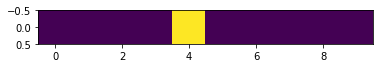

In [95]:
# img_path = train_data['before_file_path'][0]
# img = image.load_img(img_path, target_size=(224, 224)) 
# x = image.img_to_array(img) 
# x = np.expand_dims(x, axis=0) 
# #x = preprocess_input(x) 

# features = model.predict(x) 
# print(features.shape) # (1, 7, 7, 512) elephant.jpg 이미지 1개에 대한 512개의 피쳐가 7x7의 피쳐맵으로 구성되어 있습니다. 
# plt.imshow(features[:,:]) # 4번째 피쳐맵(특징)을 그려보자. cf. 0부터 시작하기에 4번째임. 

In [67]:
# Import modules
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential

In [70]:
def MyModel():
    return Sequential([Conv2D(32, (3, 3), padding='same', activation='relu'), # 28x28x32, same=zero-padding | valid=no-padding
                       MaxPool2D(), # 14x14x32, 디폴트가 2 stripe로 크기를 절반으로 줄여준다
                       Conv2D(64, (3, 3), padding='same', activation='relu'), # 14x14x64
                       MaxPool2D(), # 7x7x64
                       Conv2D(128, (3, 3), padding='same', activation='relu'), # 7x7x128
                       Flatten(), # 7x7x128 = 6272
                       Dense(128, activation='relu'), # 6272 -> 128
                       Dense(10, activation='softmax')]) # 128 -> 10

In [71]:
#모델 생성
model = MyModel()

In [72]:
model.compile(optimizer='adam',
              loss='root_mean_squared_error')

In [78]:
train_data.head(3)

,before_file_path,after_file_path,time_delta,species
0,/content/drive/MyDrive/ds_study/data/train_dat...,/content/drive/MyDrive/ds_study/data/train_dat...,29,bc
1,/content/drive/MyDrive/ds_study/data/train_dat...,/content/drive/MyDrive/ds_study/data/train_dat...,18,bc
2,/content/drive/MyDrive/ds_study/data/train_dat...,/content/drive/MyDrive/ds_study/data/train_dat...,22,bc


In [79]:
len(train_data), len(valid_data)

(1600, 400)

In [84]:
train_before_image = []
train_after_image = []
train_label = []

for i in range(1600):
  open_before = Image.open(train_data['before_file_path'][i])
  open_after = Image.open(train_data['after_file_path'][i])

  train_before_image.append(open_before)
  train_after_image.append(open_after)
  train_label.append(train_data['time_delta'][i])

In [85]:
valid_before_image = []
valid_after_image = []
valid_label = []

for i in range(len(valid_data)):
  open_before = Image.open(valid_data['before_file_path'][i])
  open_after = Image.open(valid_data['after_file_path'][i])

  valid_before_image.append(open_before)
  valid_after_image.append(open_after)
  valid_label.append(valid_data['time_delta'][i])

In [87]:
# for epoch in tqdm(range(epochs)):
#     for i in range(1600):
#         before_image = train_before_image[i]
#         after_image = train_after_image[i]
#         time_delta = train_label[i]

#         optimizer.zero_grad()
#         logit = model(before_image, after_image)
#         train_loss = (torch.sum(torch.abs(logit.squeeze(1).float() - time_delta.float())) /
#                       torch.LongTensor([batch_size]).squeeze(0))
#         train_loss.backward()
#         optimizer.step()

#         if step % 15 == 0:
#             print('\n=====================loss=======================')
#             print(f'\n=====================EPOCH: {epoch}=======================')
#             print(f'\n=====================step: {step}=======================')
#             print('MAE_loss : ', train_loss.detach().cpu().numpy())

#     valid_losses = []
#     with torch.no_grad():
#         for i in range(400):
#             valid_before = valid_before_image[i]
#             valid_after = valid_after_image[i]
#             valid_time_delta = valid_label[i]


#             logit = model(valid_before, valid_after)
#             valid_loss = (torch.sum(torch.abs(logit.squeeze(1).float() - valid_time_delta.float())) /
#                           torch.LongTensor([valid_batch_size]).squeeze(0))
#             valid_losses.append(valid_loss.detach().cpu())


#     print(f'VALIDATION_LOSS MAE : {sum(valid_losses)/len(valid_losses)}')
#     checkpoiont = {
#         'model': model.state_dict(),

#     }

#     torch.save(checkpoiont, 'checkpoiont_128.pt')

  0%|          | 0/10 [00:00<?, ?it/s]

Consider rewriting this model with the Functional API.


TypeError: ignored

In [76]:
model.fit(train_data_loader, validation_data=valid_data_loader, epochs=epochs)

ValueError: ignored

In [ ]:
#모델 학습
model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS)